In [16]:
import numpy as np
from collections import defaultdict
from itertools import islice
import re
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
data = pd.read_csv("data.csv")
#remove the first row because it is 'nan'
texts = data["Message"].tolist()[1:]
labels = data["Category"].tolist()[1:]
print(texts)
print(labels)

['Make a gap so you can weave on this straight and then we’ll have a lift and brake into 11.', 'We’ll need a 1.50 lift into turn 10.', 'Brake into 8. Easy through 8.', 'No full pedal from now.', 'I have understeer at turn 80 and oversteer at turn 80.', 'Everything is overheating.', 'I don’t like the feedback on the start. Yeah, it’s too deep.', 'Front’s still too cold. Just had a test.', 'This tyre sucks.', 'We are boxing for hard tyres.', 'Keep working those tyres.', 'Focusing on putting temperature on these tyres.', 'Medium tyres through 11 and 12.', 'Our tyres are on mode 3A.', 'box box box.', 'Plan 12. Plus 0.5.', 'We are plan B, target lap, both safety car windows are open.', 'We’ll box this lap.', 'Next tyres will be a hard ollie.', 'You have clear, clear now. The car ahead is Stroll in turn 2.', 'Wind is reducing. Wind is reduced 5 kph.', 'Everyone slow ahead.', 'Lando is over his grid box.', 'Isaac has DRS behind.', 'WooHoo, let’s go baby! Love that.', 'I am stupid. I switching

In [18]:
def generate_ngrams(text, n=2):
    """Generate n-grams from a given text."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [19]:
def build_vocab(texts, ngram_range=(1, 2)):
    """Build vocabulary for n-grams."""
    vocab = defaultdict(int)
    for text in texts:
        for n in range(ngram_range[0], ngram_range[1] + 1):
            ngrams = generate_ngrams(text, n)
            for ngram in ngrams:
                vocab[ngram] += 1
    return {word: idx for idx, word in enumerate(vocab.keys())}

In [20]:
def vectorize_texts(texts, vocab, ngram_range=(1, 2)):
    """Convert texts to vectorized form using the vocabulary."""
    vectors = []
    for text in texts:
        vec = np.zeros(len(vocab))
        for n in range(ngram_range[0], ngram_range[1] + 1):
            ngrams = generate_ngrams(text, n)
            for ngram in ngrams:
                if ngram in vocab:
                    vec[vocab[ngram]] += 1
        vectors.append(vec)
    return np.array(vectors)

In [21]:
# Build vocabulary and vectorize texts
vocab = build_vocab(texts, ngram_range=(1, 3))
X = vectorize_texts(texts, vocab, ngram_range=(1, 3))

# Encode labels
label2idx = {label: idx for idx, label in enumerate(set(labels))}
y = np.array([label2idx[label] for label in labels])
num_classes = len(label2idx)

In [22]:
def train_test_split(X, y, test_size=0.3, seed=42):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split = int(len(X) * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [23]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(probs, y_true):
    batch_size = probs.shape[0]
    log_probs = np.log(probs + 1e-9)
    loss = -log_probs[range(batch_size), y_true].mean()
    return loss

In [24]:
input_dim = X_train.shape[1]
W = np.random.randn(input_dim, num_classes) * 0.01
b = np.zeros((1, num_classes))
learning_rate = 0.01


Epoch 0: Loss = 2.0777
Epoch 10000: Loss = 0.0139
Epoch 20000: Loss = 0.0066
Epoch 30000: Loss = 0.0044
Epoch 40000: Loss = 0.0032
Epoch 50000: Loss = 0.0026
Epoch 60000: Loss = 0.0021
Epoch 70000: Loss = 0.0018
Epoch 80000: Loss = 0.0016
Epoch 90000: Loss = 0.0014


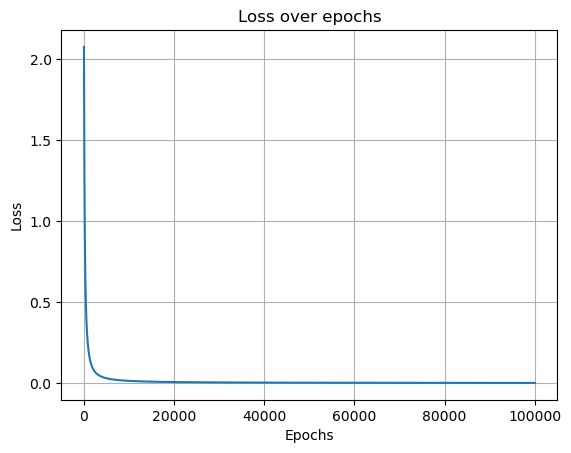

In [25]:
epochs = 100000
losses = []
for epoch in range(epochs):
    logits = np.dot(X_train, W) + b
    probs = softmax(logits)
    
    loss = cross_entropy(probs, y_train)
    losses.append(loss)
    # 수동 gradient 계산
    N = X_train.shape[0]
    one_hot = np.zeros_like(probs)
    one_hot[np.arange(N), y_train] = 1
    dL_dz = (probs - one_hot) / N  # softmax + cross entropy gradient

    # Weight & bias gradients
    dW = np.dot(X_train.T, dL_dz)
    db = np.sum(dL_dz, axis=0, keepdims=True)

    # 경사하강법 업데이트
    W -= learning_rate * dW
    b -= learning_rate * db

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

plt.plot(losses)
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [26]:
test_logits = np.dot(X_test, W) + b
test_probs = softmax(test_logits)
preds = np.argmax(test_probs, axis=1)
acc = np.mean(preds == y_test)

print("\n테스트 정확도:", acc)


테스트 정확도: 0.5


In [27]:
# 새로운 데이터 예측
new_texts = [
    "box box box", 
    "My tyres are gone.",
    "Tell him to get out of the way.",
    "We need to push for track position.",
    
]

# 1. N-gram 벡터화
new_X_data = []
for text in new_texts:
    vec = np.zeros(len(vocab))
    for n in range(1, 3):  # n-gram 범위 (1, 2)
        ngrams = generate_ngrams(text, n)
        for ngram in ngrams:
            if ngram in vocab:
                vec[vocab[ngram]] += 1
    new_X_data.append(vec)

new_X = np.array(new_X_data)

# 2. 예측
new_logits = np.dot(new_X, W) + b
new_probs = softmax(new_logits)
new_y_pred = np.argmax(new_probs, axis=1)

# 3. 예측 결과를 레이블로 변환
idx2label = {v: k for k, v in label2idx.items()}
new_y_pred_labels = [idx2label[idx] for idx in new_y_pred]

# 4. 결과 출력
for text, label in zip(new_texts, new_y_pred_labels):
    print(f"Text: \"{text}\" | Predicted Label: \"{label}\"")

Text: "box box box" | Predicted Label: "전략 및 계획"
Text: "My tyres are gone." | Predicted Label: "타이어 관련"
Text: "Tell him to get out of the way." | Predicted Label: "차량 상태 피드백"
Text: "We need to push for track position." | Predicted Label: "타이어 관련"


In [28]:
import pickle

# 모델과 필요한 데이터 저장
model_data = {
    "W": W,  # 가중치 행렬
    "b": b,  # 편향
    "vocab": vocab,  # N-gram 단어 사전
    "label2idx": label2idx,  # 레이블 -> 인덱스 매핑
    "idx2label": {v: k for k, v in label2idx.items()},  # 인덱스 -> 레이블 매핑
    "ngram_range": (1, 2)  # N-gram 범위
}

with open("ngram_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("모델이 성공적으로 저장되었습니다!")

모델이 성공적으로 저장되었습니다!
